In [81]:
import pandas as pd
import numpy as np
import csv
import json
import glob
import os
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import load_model
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.preprocessing import image
%matplotlib inline

### Input

In [144]:
target_size = (256,256)

In [157]:
loaded_image_path = '/Users/thaophan/Documents/Flatiron/Phase5_Project/images256x256/2099.jpg'

### Image classification

In [82]:
class_table = pd.read_csv('class_table.csv')

In [83]:
class_table

,Unnamed: 0,producttype,count,Class
0,0,Tshirts,7070,0
1,1,Shirts,3217,1
2,2,Casual Shoes,2846,2
3,3,Watches,2542,3
4,4,Sports Shoes,2036,4
5,5,Kurtas,1844,5
6,7,Handbags,1759,6
7,8,Heels,1323,7
8,9,Sunglasses,1073,8
9,10,Wallets,936,9


Loaded best CNN model to classify images by product types.

In [84]:
best_cnn_model_loaded = load_model('/Users/thaophan/Documents/Flatiron/Phase5_Project/cnn_model_50epoch.h5')

In [177]:
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the pixel values to [0, 1]
    return img_array


In [146]:
loaded_image_process = preprocess_loaded_image(loaded_image_path, target_size)
loaded_image_process.shape

(1, 256, 256, 3)

In [147]:
class_probabilities = best_cnn_model_loaded.predict(loaded_image_process)

1/1 [==============================] - 0s 24ms/step


In [148]:
print(class_probabilities)

[[3.7676884e-12 9.9947017e-01 8.2419223e-16 3.9003954e-20 1.8284300e-17
  5.2986090e-04 6.9242317e-10 7.9477034e-13 1.2231935e-24 3.0080227e-14]]


In [149]:
# Get the predicted class (index of the class with the highest probability)
predicted_class_index = np.argmax(class_probabilities)
predicted_class_index

1

In [150]:
int(predicted_class_index) 

1

In [151]:
class_labels = ['Tshirts','Shirts','Casual shoes','Watches','Sports shoes','Kurtas','Handbags','Heels','Sunglasses','Wallets'] 

In [154]:
# Assuming you have a list of class names in the variable class_names
predicted_class_label = class_labels[int(predicted_class_index)]
predicted_class_label

'Shirts'

### Image similarity

In [166]:
def calculate_euclidean_distance(image1_path, image2_paths, target_size):
    image1_batch = preprocess_image(image1_path, target_size)

    distances = []
    for image2_path in image2_paths: 
        if not image2_path.endswith('.DS_Store'):  # Skip .DS_Store files
            image2_batch = preprocess_image(image2_path, target_size)
            distance = siamese_model_loaded.predict([image1_batch, image2_batch])
            distances.append(distance)

    return distances

In [167]:
# Source image folder:
source_image_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Deployment/Source_image'

# List to store image paths
all_image_paths = []

# Loop through all the classes in the test data directory
for class_name in os.listdir(source_image_dir):
    # Ignore the .DS_Store file
    if class_name == '.DS_Store':
        continue

    class_dir = os.path.join(source_image_dir, class_name)

    # Check if it's a directory
    if os.path.isdir(class_dir):
        # Loop through all images in the class folder and get their paths
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            all_image_paths.append(image_path)

In [168]:
compare_image_paths = all_image_paths

Load the Siamese neural network model to compute the Euclidean distance between the loaded image (checking image) and each image in the source images.

In [169]:
def contrastive_loss(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 1
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)


In [170]:
siamese_model_loaded = load_model('/Users/thaophan/Documents/Flatiron/Phase5_Project/siamese_model2_5epoch.h5',custom_objects={'contrastive_loss': contrastive_loss})

In [171]:
distance_list = calculate_euclidean_distance(loaded_image_path,compare_image_paths,target_size)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


In [172]:
# Convert distance_list to a numpy array
distances = np.array(distance_list)

# Flatten the array to remove the extra dimension
distances = distances.flatten()

# Get the indices of the top 5 smallest distances
top_5_indices = np.argsort(distances)[:5]

# Extract the top 5 smallest distances using the indices
top_5_smallest_distances = distances[top_5_indices]

print(top_5_smallest_distances)


[0.1917539  0.1981092  0.20538807 0.21717145 0.22538646]


In [174]:
# Assuming you have already obtained the distances and top_5 as shown in the previous code

# Convert top_5_indices to a list
top_5_indices_list = top_5_indices.tolist()

# Get the paths of the top 5 most similar images
top_5_similar_images = [compare_image_paths[i] for i in top_5_indices_list]

# Print the paths of the top 5 most similar images
print("Top 5 most similar images:")
for image_path in top_5_similar_images:
    print(image_path)

Top 5 most similar images:
/Users/thaophan/Documents/Flatiron/Phase5_Project/Deployment/Source_image/1/8786.jpg
/Users/thaophan/Documents/Flatiron/Phase5_Project/Deployment/Source_image/0/2151.jpg
/Users/thaophan/Documents/Flatiron/Phase5_Project/Deployment/Source_image/1/6003.jpg
/Users/thaophan/Documents/Flatiron/Phase5_Project/Deployment/Source_image/1/10611.jpg
/Users/thaophan/Documents/Flatiron/Phase5_Project/Deployment/Source_image/1/57290.jpg


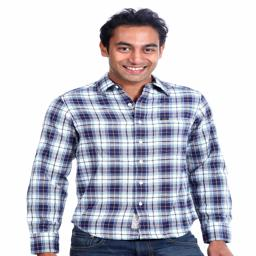

In [175]:
# Display the loaded image:
loaed_image_display = Image.open(loaded_image_path)
display(loaed_image_display)

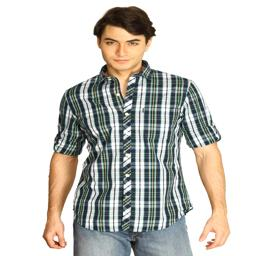

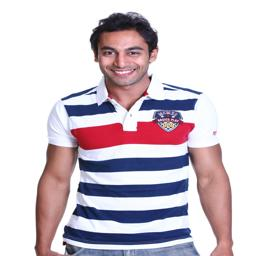

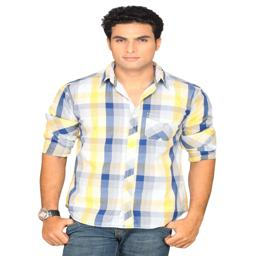

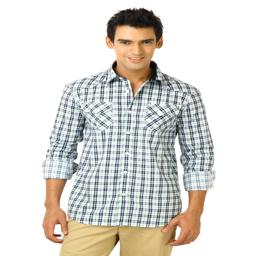

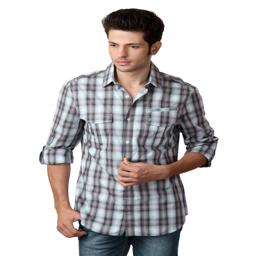

In [176]:
# Loop through the top 5 image paths and display each image
for image_path in top_5_similar_images:
    simiar_image = Image.open(image_path)
    display(simiar_image)